In [1]:
%%capture
import stata_setup, os
if os.name == 'nt':
    stata_setup.config('C:/Program Files/Stata17/','mp')
else:
    stata_setup.config('/usr/local/stata17','mp')

In [2]:
%%stata -qui

use "../data/data", clear
rename log_automated_readability_index ARI
quietly tabulate year, generate(y_)
quietly tabulate cluster, generate(c_)

local journals ecm jpe qje res  //AER based category

local jel_imp a_imp b_imp c_imp  e_imp f_imp g_imp h_imp i_imp j_imp k_imp /// 
		l_imp m_imp n_imp o_imp p_imp q_imp r_imp y_imp z_imp // D JEL based case


. 
. set scheme white_piyg

. twoway (scatter ARI log_flesch_kincaid_grade_level) ///
>        (function y=x, range(1.5 4.5)) ///
>        , xscale(range(1.5 4.5)) yscale(range(1.5 4.5))

. 


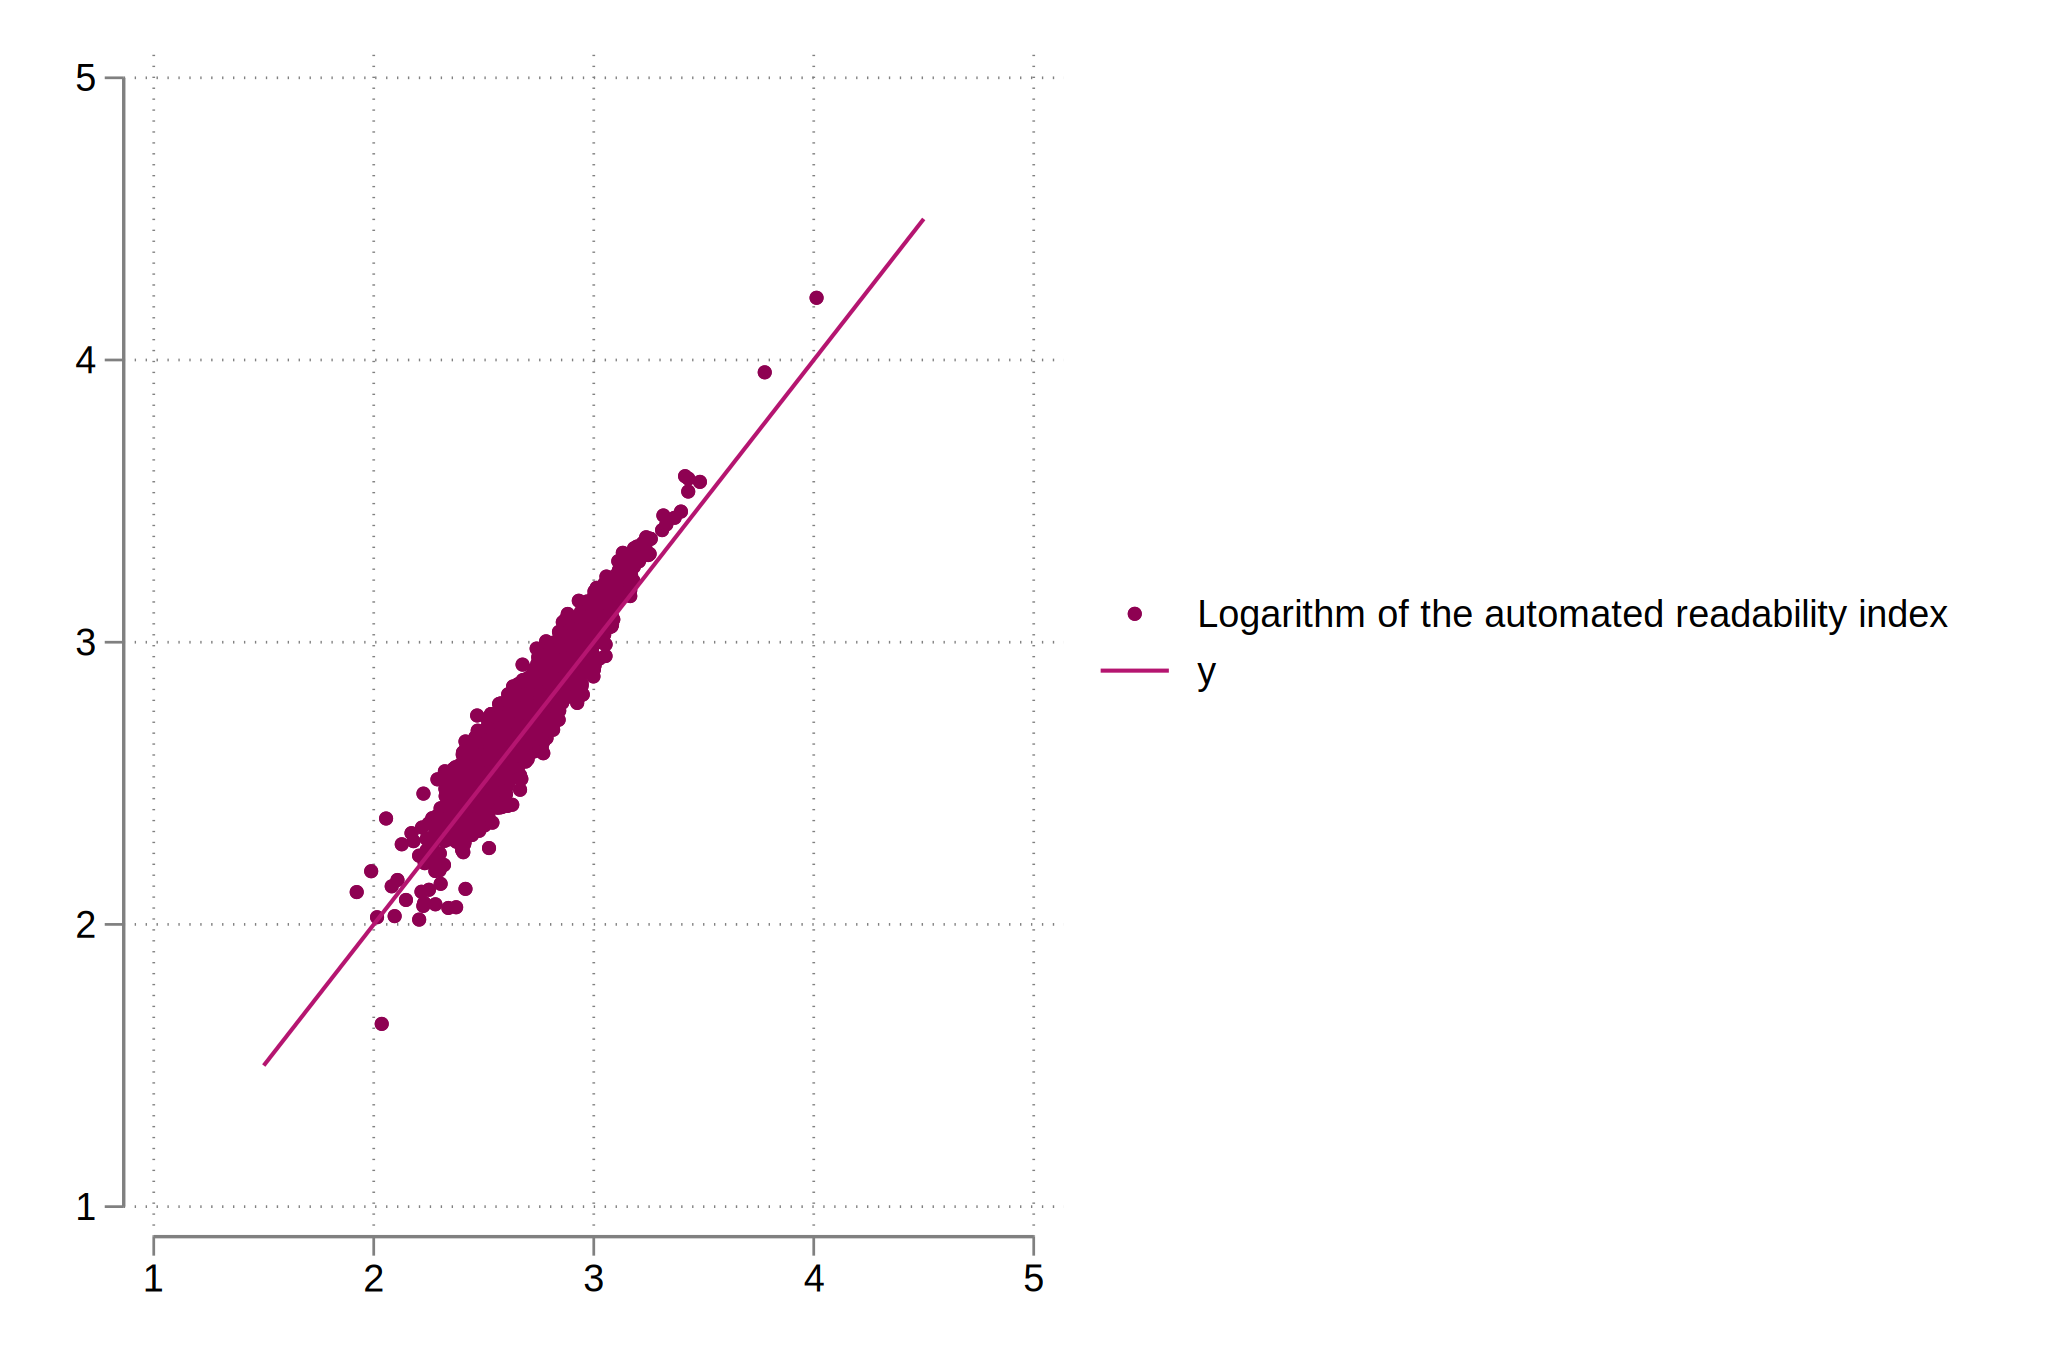

In [3]:
%%stata

set scheme white_piyg
twoway (scatter ARI log_flesch_kincaid_grade_level) ///
       (function y=x, range(1.5 4.5)) ///
       , xscale(range(1.5 4.5)) yscale(range(1.5 4.5))

In [4]:
%%stata -qui
#delimit ;
reg ARI log_num_authors log_num_pages both_genders only_males
			`journals' `jel_imp' y_2-y_20  c_2-c_215  jel_flag, vce(cluster cluster);
matrix b_selected = e(b)[1,"log_num_authors"],e(b)[1,"log_num_pages"],
                    e(b)[1,"both_genders"],e(b)[1,"only_males"],e(b)[1,"_cons"];
#delimit cr

In [5]:
%%stata
matrix list b_selected


b_selected[1,5]
    log_num_au~s  log_num_pa~s  both_genders    only_males         _cons
y1     .00218908     .02298592     .01266277      .0189557     2.6904442


In [6]:
%%stata -qui
#delimit ;
vl set log_num_authors log_num_pages both_genders only_males
       `journals' `jel_imp' y_2-y_20  c_2-c_215 jel_flag
       , dummy clear nonotes;
vl create fe = vldummy - (only_males both_genders jel_flag);
vl substitute mfe = i.fe;
vl create controls = vlcontinuous;
vl create controls_dummy = (both_genders jel_flag);
vl substitute baseline = i.controls_dummy controls;
vl rebuild;
#delimit cr

In [7]:
%%stata -qui
#delimit ;
reg ARI i.only_males $baseline $mfe, vce(cluster cluster);
#delimit cr

In [8]:
%%stata
estimates table, keep(log_num_authors log_num_pages 1.both_genders 1.only_males) b(%5.4f) star varwidth(25)


----------------------------------------
                 Variable |   Active    
--------------------------+-------------
          log_num_authors |  0.0022     
            log_num_pages |  0.0230***  
           1.both_genders |  0.0127     
             1.only_males |  0.0190***  
----------------------------------------
Legend: * p<0.05; ** p<0.01; *** p<0.001


In [9]:
%%stata -qui
#delimit ;
xporegress ARI i.only_males $baseline,
			controls($mfe)
            vce(cluster cluster) rseed(42)
            xfolds(20) ;
estimates store xpo_plugin;
#delimit cr

In [10]:
%%stata
estimates restore xpo_plugin
xporegress


. estimates restore xpo_plugin
(results xpo_plugin are active now)

. xporegress

Cross-fit partialing-out             Number of obs                =      4,988
linear model                         Number of controls           =        512
                                     Number of selected controls  =        100
                                     Number of folds in cross-fit =         20
                                     Number of resamples          =          1
                                     Wald chi2(5)                 =      17.66
                                     Prob > chi2                  =     0.0034

                              (Std. err. adjusted for 215 clusters in cluster)
------------------------------------------------------------------------------
             |               Robust
         ARI | Coefficient  std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
1.only_male

In [11]:
%%stata
summarize automated_readability_index, detail
local cutoff = r(p95)
gen int ARI_01 = (automated_readability_index >= `cutoff')


. summarize automated_readability_index, detail

      Automated readability index score for the article
-------------------------------------------------------------
      Percentiles      Smallest
 1%     10.14504       5.194678
 5%     11.81832       7.517143
10%     12.72031       7.581272       Obs               4,988
25%     14.18133       7.610606       Sum of wgt.       4,988

50%     15.98628                      Mean           16.23712
                        Largest       Std. dev.      3.149588
75%     17.86968       35.86604
90%     20.04869         36.178       Variance       9.919907
95%     21.38507       52.27347       Skewness       1.885853
99%     25.20484       68.08047       Kurtosis       22.74376

. local cutoff = r(p95)

. gen int ARI_01 = (automated_readability_index >= `cutoff')

. 


In [12]:
%stata summarize ARI_01


    Variable |        Obs        Mean    Std. dev.       Min        Max
-------------+---------------------------------------------------------
      ARI_01 |      4,988    .0499198    .2178011          0          1


In [13]:
%%stata -qui
#delimit ;
logit ARI_01 i.only_males $baseline $mfe, vce(cluster cluster) nolog;
#delimit cr

In [14]:
%%stata
estimates table, keep(log_num_authors log_num_pages 1.both_genders 1.only_males) b(%5.4f) star varwidth(25)


----------------------------------------
                 Variable |   Active    
--------------------------+-------------
          log_num_authors | -0.1506     
            log_num_pages |  0.7096***  
           1.both_genders |  0.6463     
             1.only_males |  0.6594**   
----------------------------------------
Legend: * p<0.05; ** p<0.01; *** p<0.001


In [15]:
%%stata -qui
#delimit ;
margins, dydx(only_males) at(log_num_pages=(1(0.5)4.5)
                             log_num_authors=0.60205999132 (base) _factor);
#delimit cr


. set scheme white_piyg

. marginsplot, yline(0) recast(line) title("Marginal Effects of Only Males on A
> RI")

Variables that uniquely identify margins: log_num_pages

. 


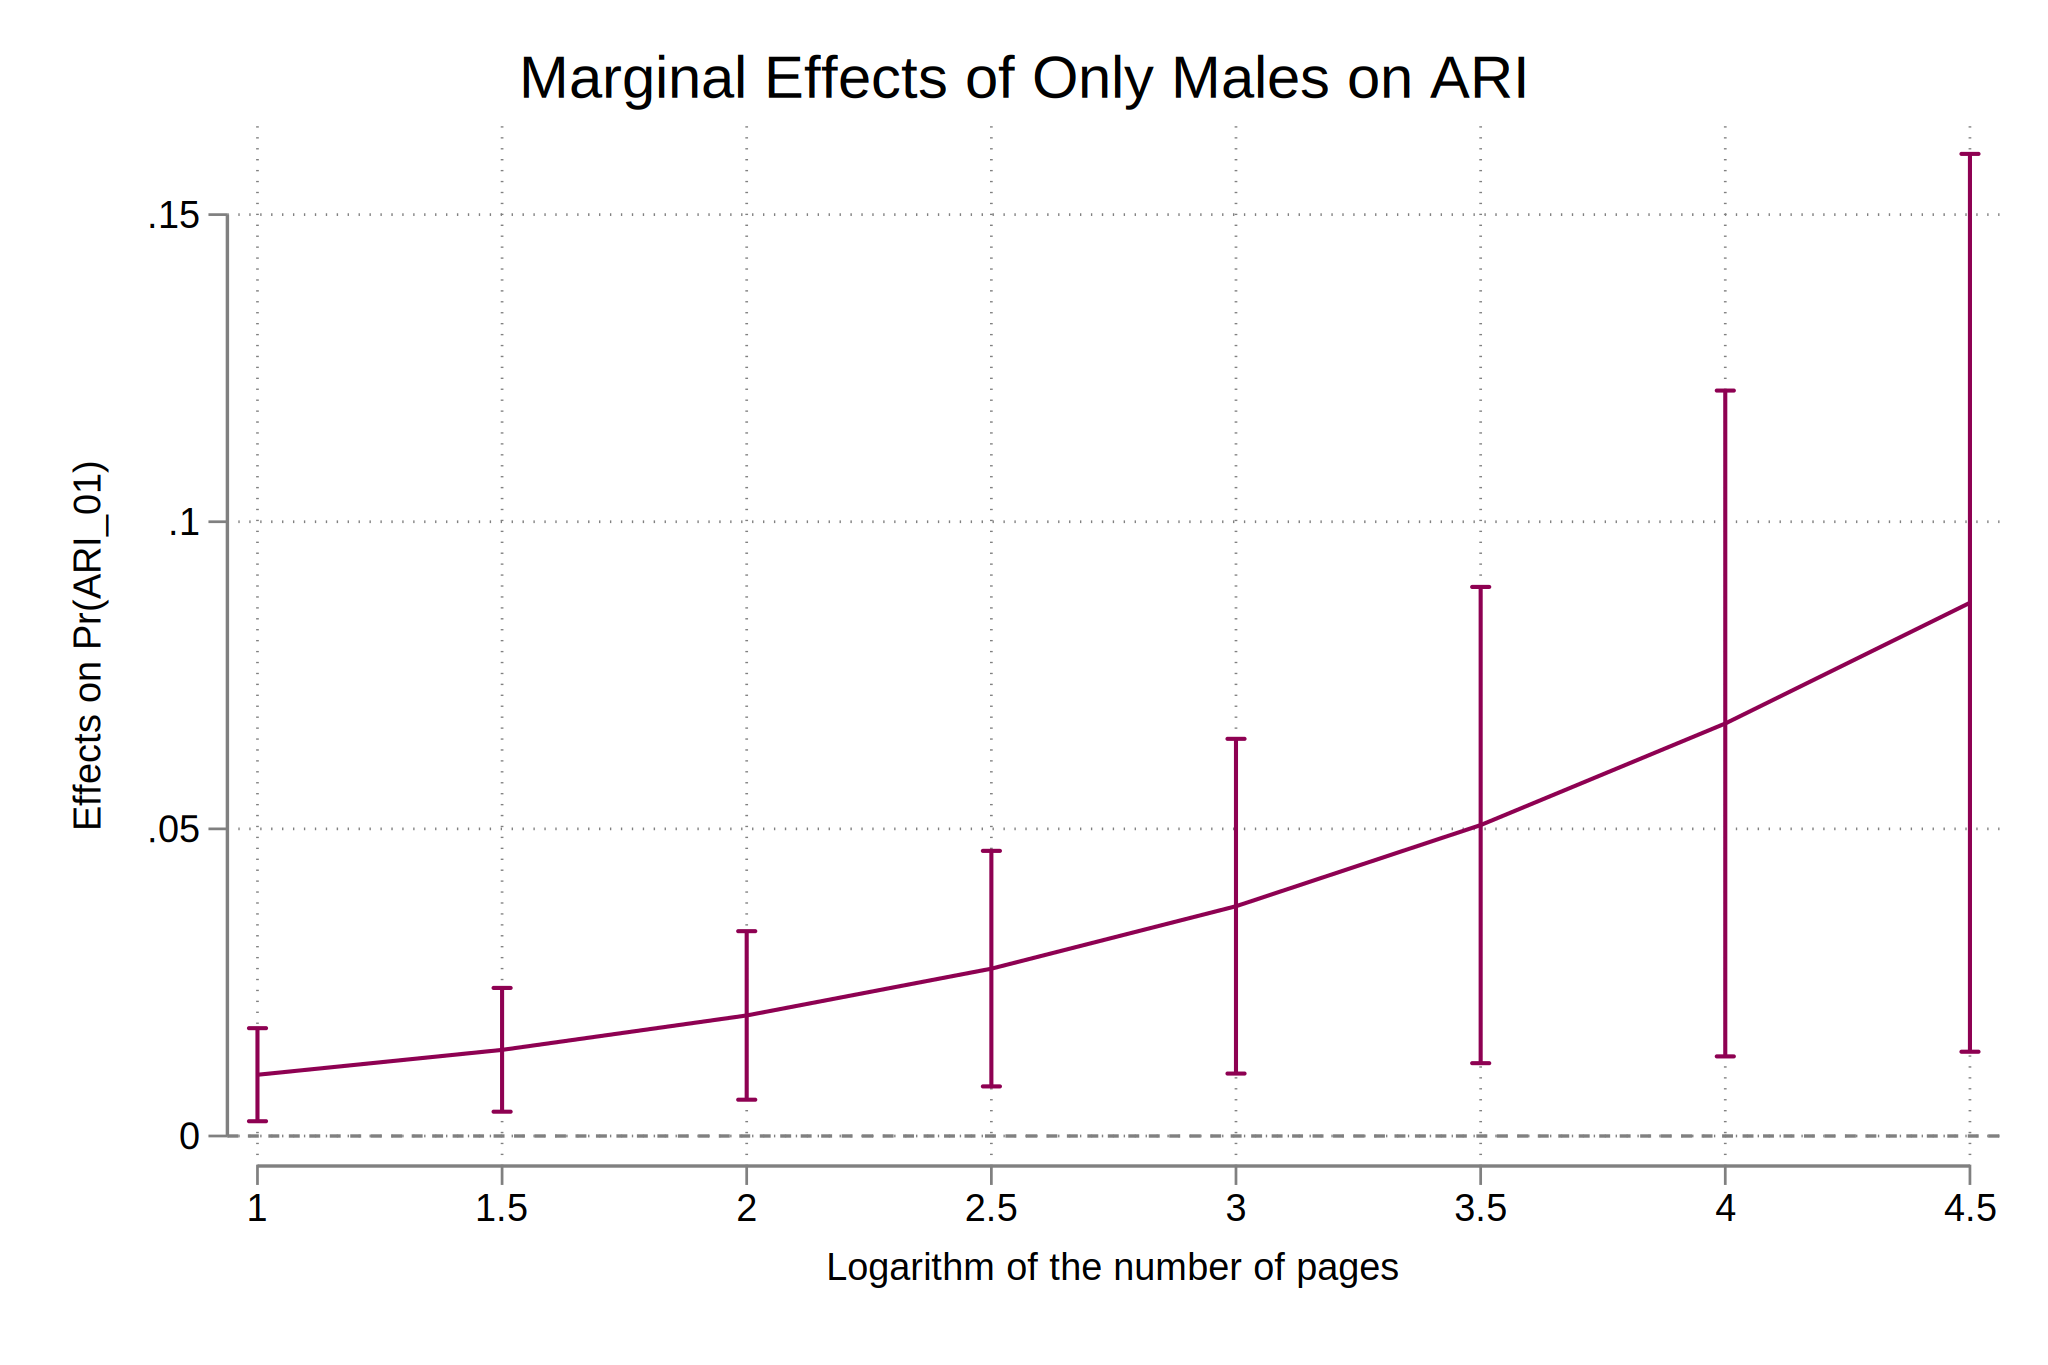

In [16]:
%%stata
set scheme white_piyg
marginsplot, yline(0) recast(line) title("Marginal Effects of Only Males on ARI")

In [17]:
%%stata -qui

use "../data/data", clear

quietly tabulate year, generate(y_)
quietly tabulate cluster, generate(c_)

local journals aer ecm jpe res  //QJE based category

local jel_imp a_imp b_imp d_imp e_imp f_imp g_imp h_imp i_imp j_imp k_imp /// 
		l_imp m_imp n_imp o_imp p_imp q_imp r_imp y_imp z_imp // C JEL based case

summarize num_sentences, detail
local cutoff_sentences = r(p5)
gen int excess_sentences = num_sentences - `cutoff_sentences'
replace excess_sentences = 0 if excess_sentences < 0

In [18]:
%%stata -qui
#delimit ;
vl set log_num_authors log_num_pages both_genders only_males
       `journals' `jel_imp' y_1-y_10 y_12-y_20  c_2-c_215 jel_flag
       , dummy clear nonotes;
vl create fe = vldummy - (only_males both_genders jel_flag);
vl substitute mfe = i.fe;
vl create controls = vlcontinuous;
vl create controls_dummy = (both_genders jel_flag);
vl substitute baseline = i.controls_dummy controls;
vl rebuild;
#delimit cr

In [19]:
%%stata
#delimit ;
poisson excess_sentences i.only_males $baseline $mfe, vce(cluster cluster) nolog;
#delimit cr


. #delimit ;
delimiter now ;
. poisson excess_sentences i.only_males $baseline $mfe, vce(cluster cluster) no
> log;

Poisson regression                                      Number of obs =  4,988
                                                        Wald chi2(78) =      .
                                                        Prob > chi2   =      .
Log pseudolikelihood = -9020.3735                       Pseudo R2     = 0.0662

                              (Std. err. adjusted for 215 clusters in cluster)
------------------------------------------------------------------------------
             |               Robust
excess_sen~s | Coefficient  std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
1.only_males |  -.0479756   .0157817    -3.04   0.002    -.0789072    -.017044
1.both_gen~s |  -.0331594   .0200053    -1.66   0.097     -.072369    .0060503
  1.jel_flag |   .0238852   .0142956     1.67   0.095  

In [20]:
%%stata
estimates table, keep(log_num_authors log_num_pages 1.both_genders 1.only_males) b(%5.4f) star varwidth(25)


----------------------------------------
                 Variable |   Active    
--------------------------+-------------
          log_num_authors | -0.0090     
            log_num_pages |  0.4039***  
           1.both_genders | -0.0332     
             1.only_males | -0.0480**   
----------------------------------------
Legend: * p<0.05; ** p<0.01; *** p<0.001


In [21]:
%%stata -qui
#delimit ;
ppmlhdfe excess_sentences i.only_males $baseline,
                          absorb($mfe)  vce(cluster cluster) d;
#delimit cr

In [22]:
%%stata
estimates table, keep(log_num_authors log_num_pages 1.both_genders 1.only_males) b(%5.4f) star varwidth(25)


----------------------------------------
                 Variable |   Active    
--------------------------+-------------
          log_num_authors | -0.0090     
            log_num_pages |  0.4039***  
           1.both_genders | -0.0332     
             1.only_males | -0.0480**   
----------------------------------------
Legend: * p<0.05; ** p<0.01; *** p<0.001


In [23]:
%%stata
nlcom (100*exp(_b[1.only_males]-1)) 


       _nl_1: 100*exp(_b[1.only_males]-1)

------------------------------------------------------------------------------
excess_sen~s | Coefficient  Std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
       _nl_1 |   35.06469    .553405    63.36   0.000     33.98003    36.14934
------------------------------------------------------------------------------


In [24]:
%%stata
margins, dydx(only_males)


Average marginal effects                                 Number of obs = 4,978
Model VCE: Robust

Expression: Predicted mean of excess_sentences, predict()
dy/dx wrt:  1.only_males

------------------------------------------------------------------------------
             |            Delta-method
             |      dy/dx   std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
1.only_males |   -.122466   .0407555    -3.00   0.003    -.2023453   -.0425868
------------------------------------------------------------------------------
Note: dy/dx for factor levels is the discrete change from the base level.


In [25]:
%%stata -qui
#delimit ;
margins, dydx(only_males) at(log_num_pages=(1(0.5)4.5)
                             log_num_authors=0.60205999132 (base) _factor);
#delimit cr

In [26]:
%%stata -qui
#delimit ;
cd "../data/";
margins, dydx(only_males) at(log_num_pages=(1(0.5)4.5)
                           log_num_authors=(0 (0.25)2) (base) _factor)
                           saving(predictions_2, replace);
#delimit cr

In [27]:
%%stata -qui
use predictions_2, clear
rename _at4 log_num_pages
rename _at5 log_num_authors 
rename _margin delta_hat 
save predictions_2, replace

In [28]:
# Import the necessary Python packages
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('WebAgg')
import matplotlib.pyplot as plt


# Read (import) the Stata dataset “predictions_2.dta”
# into a pandas data frame named “data”
data = pd.read_stata("predictions_2.dta")


# Define a 3-D graph named “ax”
ax = plt.axes(projection='3d')

# Specify the view angle of the graph
ax.view_init(elev=30, azim=200)

# Render the graph
ax.plot_trisurf(data['log_num_authors'], data['log_num_pages'], data['delta_hat'],cmap=plt.cm.Spectral_r)

# Specify the axis ticks
ax.set_xticks(np.arange(0, 2, step=0.25))
ax.set_yticks(np.arange(1, 4.5, step=0.5))
ax.set_zticks(np.arange( -.1, 0, step=0.02))


# Specify the title and axis titles
ax.set_title("")
ax.set_xlabel("log(Number of Authors)")
ax.set_ylabel("log(Number of Pages)")
ax.zaxis.set_rotate_label(False)

# Save the graph
plt.savefig("../figures/Margins3d_2.png")

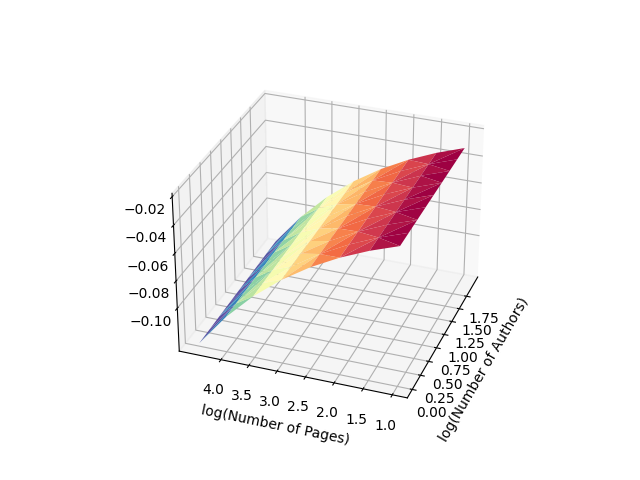

In [30]:
# Showing the graph
from IPython.display import Image
Image("../figures/Margins3d_2.png")